<a href="https://colab.research.google.com/github/Gousepasha789/Tea-Leaf-disease-detection/blob/main/Tea_Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import required libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import os

print("All required libraries imported successfully!")

All required libraries imported successfully!


In [2]:
# Step 2: Mount Google Drive and load dataset

from google.colab import drive
drive.mount('/content/drive')

# Dataset base path
base_path = "/content/drive/MyDrive/teaLeafBD"

print("Google Drive mounted successfully!")
print(f"Dataset Path set to: {base_path}")

Mounted at /content/drive
Google Drive mounted successfully!
Dataset Path set to: /content/drive/MyDrive/teaLeafBD


In [12]:
# Step 3: Define image parameters

IMAGE_SIZE = (96, 96)
BATCH_SIZE = 16
CHANNELS = 3

print("Image parameters set successfully!")
print(f"Image Size     : {IMAGE_SIZE}")
print(f"Batch Size     : {BATCH_SIZE}")
print(f"Channels       : {CHANNELS} (RGB)")

Image parameters set successfully!
Image Size     : (96, 96)
Batch Size     : 16
Channels       : 3 (RGB)


In [13]:
#Step 4: Create Data Generators & Load Dataset

VAL_SPLIT = 0.20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=VAL_SPLIT
)

train_data = train_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)
val_data = val_datagen.flow_from_directory(
    base_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)
print("\nDataset Loaded Successfully!")
print(f"Training samples   : {train_data.samples}")
print(f"Validation samples : {val_data.samples}")
print(f"Number of Classes  : {train_data.num_classes}")
print("Classes:", list(train_data.class_indices.keys()))

Found 4223 images belonging to 7 classes.
Found 1053 images belonging to 7 classes.

Dataset Loaded Successfully!
Training samples   : 4223
Validation samples : 1053
Number of Classes  : 7
Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']



Class Labels Mapping:
   0 → 1. Tea algal leaf spot
   1 → 2. Brown Blight
   2 → 3. Gray Blight
   3 → 4. Helopeltis
   4 → 5. Red spider
   5 → 6. Green mirid bug
   6 → 7. Healthy leaf

Dataset Analysis:
Total Training Samples   : 4223
Total Validation Samples : 1053
Number of Classes        : 7


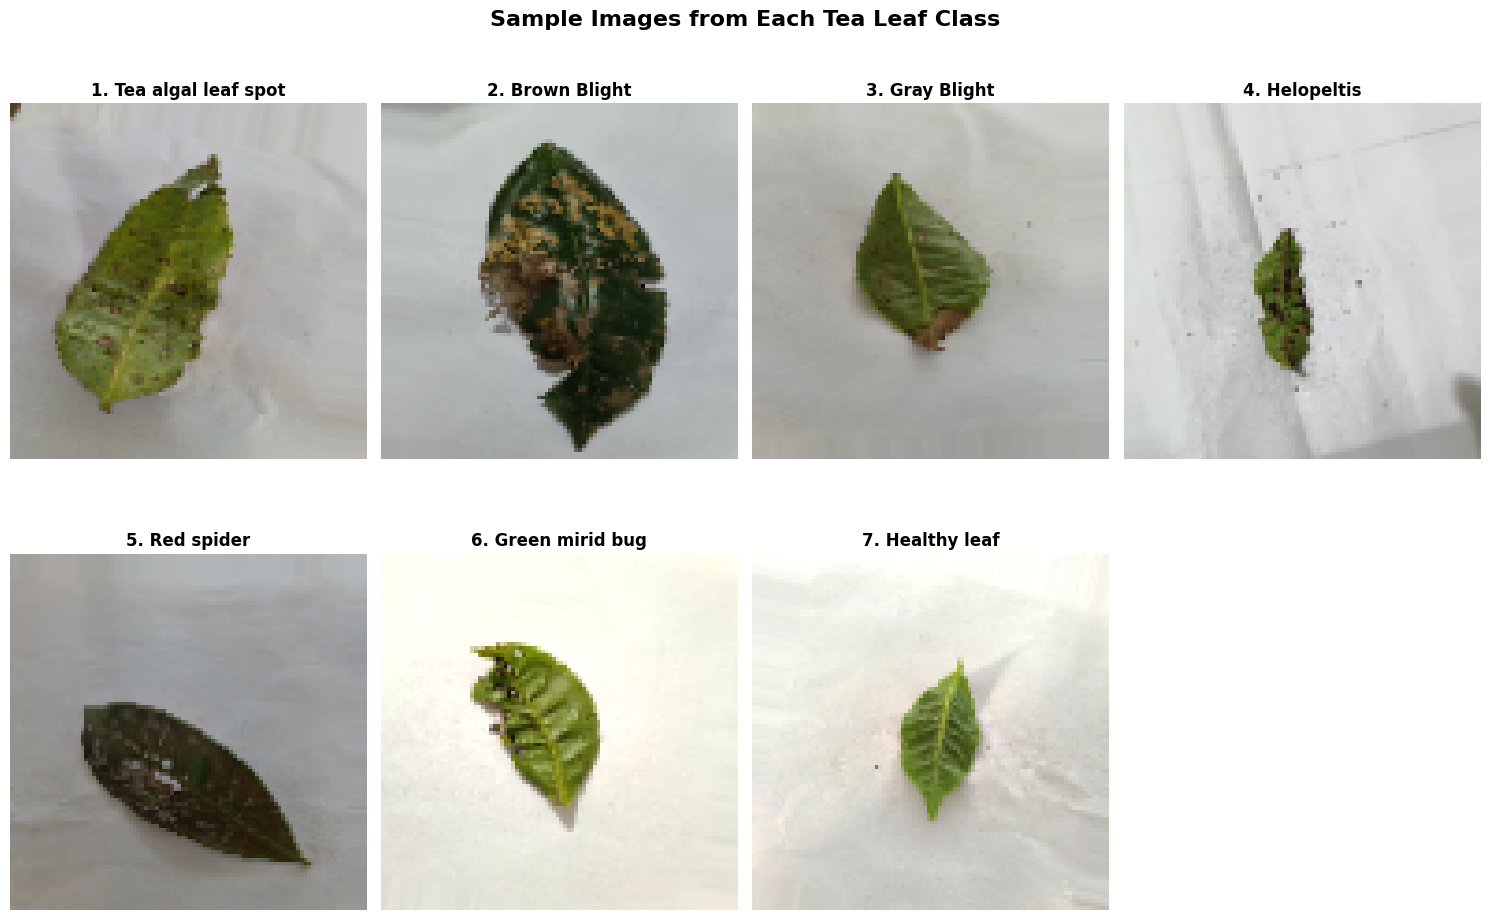

In [14]:
# Step 5: Explore Dataset

print("\nClass Labels Mapping:")
for class_name, idx in train_data.class_indices.items():
    print(f"   {idx} → {class_name}")

print(f"\nDataset Analysis:")
print(f"Total Training Samples   : {train_data.samples}")
print(f"Total Validation Samples : {val_data.samples}")
print(f"Number of Classes        : {train_data.num_classes}")

class_names = list(train_data.class_indices.keys())
plt.figure(figsize=(15, 10))

images, labels = next(train_data)

for i in range(min(len(class_names), 8)):
    plt.subplot(2, 4, i+1)
    class_indices = np.where(np.argmax(labels, axis=1) == i)[0]
    if len(class_indices) > 0:
        idx = class_indices[0]
        plt.imshow(images[idx])
        plt.title(f"{class_names[i]}", fontsize=12, fontweight='bold')
    plt.axis("off")

plt.suptitle("Sample Images from Each Tea Leaf Class", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# Step 6: Build CNN Model

num_classes = train_data.num_classes

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()
print(f"\nModel created with {num_classes} output classes")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,489,671 (9.50 MB)

 Trainable params: 2,489,671 (9.50 MB)

 Non-trainable params: 0 (0.00 B)


Model created with 7 output classes


In [16]:
# Step 7: Train the CNN Model

checkpoint = ModelCheckpoint("best_tealeaf_model.keras",
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=5,
                           restore_best_weights=True,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

print("Starting CNN Training... ")

EPOCHS = 20

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print("\nTraining finished! Best CNN model saved as 'best_tealeaf_model.keras'")

Starting CNN Training... 
Epoch 1/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.2458 - loss: 2.3617
Epoch 1: val_accuracy improved from -inf to 0.40076, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 179s 668ms/step - accuracy: 0.2458 - loss: 2.3609 - val_accuracy: 0.4008 - val_loss: 1.7332 - learning_rate: 3.0000e-04
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.3752 - loss: 1.7575
Epoch 2: val_accuracy improved from 0.40076 to 0.48813, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 196s 742ms/step - accuracy: 0.3752 - loss: 1.7573 - val_accuracy: 0.4881 - val_loss: 1.4739 - learning_rate: 3.0000e-04
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.4198 - loss: 1.5929
Epoch 3: val_accuracy improved from 0.48813 to 0.53941, saving model to best_tealeaf_model.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 196s 744ms/step - accuracy: 0.4198 - loss: 1.5928 - val_accuracy: 0.5394 - val_loss: 1.3109 - l

Loading best model for evaluation...
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 353ms/step - accuracy: 0.7297 - loss: 0.8250
Final Validation Accuracy: 71.70%

Training & Evaluation Complete!
Total Epochs Run : 20


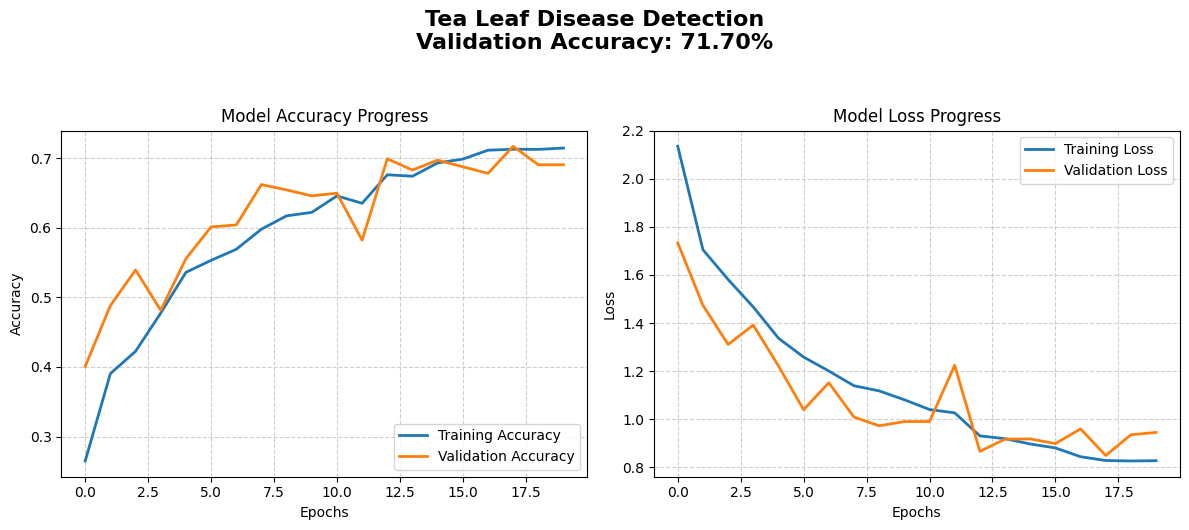

In [18]:
# Step 8: Evaluate Model & Visualize Training

# Final evaluation
print("Loading best model for evaluation...")
best_model = tf.keras.models.load_model("best_tealeaf_model.keras")

loss, acc = model.evaluate(val_data)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

print("\nTraining & Evaluation Complete!")
print(f"Total Epochs Run : {len(history.history['accuracy'])}")

# Plot training history
plt.figure(figsize=(12,5))

plt.suptitle(f"Tea Leaf Disease Detection\nValidation Accuracy: {acc*100:.2f}%",
             fontsize=16, fontweight='bold', y=1.05)

# Accuracy subplot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy Progress')
plt.grid(True, linestyle='--', alpha=0.6)
plt.box(True)

# Loss subplot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss Progress')
plt.grid(True, linestyle='--', alpha=0.6)
plt.box(True)

plt.tight_layout()
plt.show()